In [59]:
!pip install yfinance
!pip install seaborn
!pip install textblob
!pip install bs4

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, clone
from joblib import Parallel, delayed
from scipy.optimize import minimize
import datetime

import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# Objectif du projet

L'idée de notre travail est de mettre en place une stratégie Equity et d'investir sur 5 secteurs (Banking, Real Estate, Automobile, Energy, Tourism) plutôt que sur des entreprises individuelles. En outre, en plus d'un modèle de Markovitz classique qui nous servira de benchmark, nous utiliserons un signal construit à partir de l'analyse de sentiments des phrases issues des rapports *beige book* (*National Summary* et New York). Ce signal est destiné à distordre l'allocation optimale de Markovitz pour valoriser les secteurs estimés en bonne santé par l'état américain.


# Scrapping des données du *beige book*

La première étape consiste à scapper les données textuelles du beige book.
Nous nous concentrons sur le *national summary* et le rapport de New York.
Nous commençons par différentes fonctions qui seront utiles pour le scrapping, notamment pour générer des combinaisons de (année : de 2014 à 2022, mois : de 01 à 12, région du rapport :  su pour summary et ny pour New York).

In [47]:
def gen(skip=False):
    """
    Generator function that yields tuples representing combinations of year, month, and region.

    Parameters:
    - skip (bool): Optional parameter to skip previously processed entries based on a CSV file.

    Yields:
    tuple: A tuple containing (year, month, region) for each combination.

    """
    
    regions = ("su", "ny")

    for year in range(2014, 2023):
        os.makedirs(f"txt/{year}", exist_ok=True)
        for month in range(1, 13):
            if skip and (year, month) in norelease:
                continue
            os.makedirs(f"txt/{year}/{month:02d}", exist_ok=True)
            for region in regions:
                yield year, month, region

def get_txt_file(t):
    """
    Get the path of the text file based on the input tuple.

    Parameters:
    - t (tuple): A tuple containing (year, month, region).

    Returns:
    str: File path of the corresponding text file.

    """
    return f"txt/{t[0]}/{t[1]:02d}/{t[0]}-{t[1]:02d}-{t[2]}.txt"

Nous créons ensuite l'environnement pour stocker les données du beige book :

In [48]:
folder_path = 'out/csv/'

# Check if the folder does not exist, then create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

# Create an empty CSV file named "missing" in the folder
csv_file_path = os.path.join(folder_path, 'missing.csv')
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

print(f"Empty CSV file '{csv_file_path}' created successfully.")

Folder 'out/csv/' created successfully.
Empty CSV file 'out/csv/missing.csv' created successfully.


Nous scrappons ensuite les données :

In [49]:
def scrape(skip=False):
    """
    Scrape text data from a website and save it to local text files.

    Parameters:
    - skip (bool): Optional parameter to skip previously scraped entries.

    """
    # Open CSV file to record missing entries
    errorfile = open("out/csv/missing.csv", "w")
    errorfile.write("year,month,region\n")

    # Iterate over year, month, and region combinations
    for year, month, region in gen(skip):
        print(f"{year}", f"{month:02d}", f"{region}", end=" ")
        header = "https://www.minneapolisfed.org/beige-book-reports/"
        url = header + f"{year}/{year}-{month:02d}-{region}"
        
        try:
            # Get text content from the URL
            txt = get_text(url)
            
            # Save the text to a local file
            with open(get_txt_file((year, month, region)), "w") as f:
                f.write(txt)
            
            print("Available")
        
        except ValueError:
            # Handle cases where the URL is not found (404 error)
            errorfile.write(f"{year},{month:02d},{region}\n")
            print("Not Available")

    # Close the CSV file
    errorfile.close()

def get_text(url):
    """
    Get text content from a given URL.

    Parameters:
    - url (str): The URL to retrieve text content from.

    Returns:
    str: The raw text content.

    """
    # Send a GET request to the URL
    r = requests.get(url)
    
    # Check if the URL is not found (404 error)
    if r.status_code == 404:
        raise ValueError
    
    # Check for other HTTP status codes
    if r.status_code != 200:
        raise RuntimeError(f"Status Code: {r.status_code}")
    
    # Parse HTML content with BeautifulSoup
    soup = BeautifulSoup(r.text, features="html5lib")
    
    # Extract text from specific HTML elements
    div = soup.find("div", class_="col-sm-12 col-lg-8 offset-lg-1")
    raw = re.sub(r"\s*\n\s*", "\n", div.text).strip()
    raw = raw.split("\n", 3)[3]
    
    return raw


L'étape de scrapping concrète des données prend environ 3 minutes : pour ne pas avoir à répéter l'étape, nous avons joint à notre mail un fichier "txt.zip" qu'il suffit décompresser dans votre espace de travail et qui contient directement les *beige book* utiles pour la suite.

In [50]:
scrape()

2014 01 su Available
2014 01 ny Available
2014 02 su Not Available
2014 02 ny Not Available
2014 03 su Available
2014 03 ny Available
2014 04 su Available
2014 04 ny Available
2014 05 su Not Available
2014 05 ny Not Available
2014 06 su Available
2014 06 ny Available
2014 07 su Available
2014 07 ny Available
2014 08 su Not Available
2014 08 ny Not Available
2014 09 su Available
2014 09 ny Available
2014 10 su Available
2014 10 ny Available
2014 11 su Not Available
2014 11 ny Not Available
2014 12 su Available
2014 12 ny Available
2015 01 su Available
2015 01 ny Available
2015 02 su Not Available
2015 02 ny Not Available
2015 03 su Available
2015 03 ny Available
2015 04 su Available
2015 04 ny Available
2015 05 su Not Available
2015 05 ny Not Available
2015 06 su Available
2015 06 ny Available
2015 07 su Available
2015 07 ny Available
2015 08 su Not Available
2015 08 ny Not Available
2015 09 su Available
2015 09 ny Available
2015 10 su Available
2015 10 ny Available
2015 11 su Not Avail

Nous supprimons les fichiers vides correspondants aux mois où aucun *beige book* n'a été publié :

In [55]:
def delete_empty_folders(root):

    deleted = set()
    
    for current_dir, subdirs, files in os.walk(root, topdown=False):

        still_has_subdirs = False
        for subdir in subdirs:
            if os.path.join(current_dir, subdir) not in deleted:
                still_has_subdirs = True
                break
    
        if not any(files) and not still_has_subdirs:
            os.rmdir(current_dir)
            deleted.add(current_dir)

    return deleted

delete_empty_folders(root)

In [56]:
root = '...\\txt'
delete_empty_folders(root)

{'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2014\\02',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2014\\05',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2014\\08',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2014\\11',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2015\\02',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2015\\05',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2015\\08',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2015\\11',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2016\\02',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2016\\05',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2016\\08',
 'c:\\Users\\avich\\Desktop\\ENSAE\\3A\\MLPT\\projet\\beige-book\\txt\\2016\\12',
 'c:\\Users\\avi

# Création des secteurs et analyse de sentiment

Nous créons ensuite la liste des mots-clés des différents secteurs que nous allons chercher dans les *beige book* pour constituer notre corpus de phrases :

In [57]:
automobile_related_words = [
    'Automobile', 'Automobiles', 'Auto', 'Autos', 'Car', 'Cars', 'Motor Vehicle', 'Motor Vehicles', 'Vehicle', 'Vehicles',
    'Automotive', 'Auto Manufacturing', 'Car Production', 'Car Industry', 'Auto Sector', 'Car Manufacturing',
    'Motorcar', 'Motorcars', 'Vehicle Manufacturing', 'Auto Sector', 'Auto Production', 'Car Assembly',
    'Auto Manufacturing', 'Car Fabrication', 'Vehicle Assembly', 'Motorcar Industry', 'Auto Fabrication',
    'Automotive Assembly', 'Car Fabrication', 'Motorcar Manufacturing', 'Auto Assembly', 'Auto Fabrication',
    'Car Assembling', 'Motor Vehicle Industry', 'Auto Industry', 'Vehicle Fabrication'
]

real_estate_related_words = [
    'Real Estate', 'Real Estates', 'Property', 'Properties', 'Realty', 'Real Property', 'Real Assets', 'Realty Sector',
    'Real Estate Market', 'Real Assets Sector', 'Real Property Industry', 'Realty Market', 'Land & Property',
    'Real Estate Development', 'Realty Business', 'Property Market', 'Real Estate Sector', 'Land & Assets',
    'Real Estate Business', 'Realty Development', 'Real Property Market', 'Realty Industry', 'Real Estate Investment',
    'Realty Sector', 'Property Business', 'Real Assets Market', 'Real Property Business', 'Realty Investment',
    'Real Estate Business', 'Property Development'
]

tourism_related_words = [
    'Tourism', 'Travel', 'Hospitality', 'Leisure', 'Vacation', 'Tourist', 'Tourists', 'Tourism Business', 'Travel Business',
    'Holiday', 'Tourist Business', 'Vacation Business', 'Leisure Business', 'Hospitality Business', 'Tourism Market',
    'Travel Market', 'Vacation Market', 'Leisure Market', 'Tourist Market', 'Hospitality Market', 'Travel & Tourism',
    'Leisure & Hospitality', 'Tourist & Vacation', 'Holiday Sector', 'Tourism Development', 'Travel Development'
]

banking_related_words = [
    'Financial', 'Banking', 'Financial Services', 'Finance', 'Banking & Investment', 'Finances', 'Banking Services',
    'Financial & Banking', 'Investment', 'Banking & Finance', 'Financial Market', 'Banking', 'Finance & Investment',
    'Financial Business', 'Investments', 'Banking & Economics', 'Finance & Banking', 'Financial & Investment',
    'Banking & Finance Industry', 'Banking & Finance Sector', 'Investment & Finance', 'Financial & Banking Industry',
    'Financial & Investment Industry', 'Banking & Investment Industry', 'Finance & Banking Business',
    'Banking & Investment Business', 'Financial & Banking Services', 'Investment & Banking', 'Finance & Investment Business',
    'Banking & Financial Services'
]

energy_related_words = [
    'Energy', 'Power', 'Fuel', 'Energy Production', 'Renewable Energy', 'Energy & Power', 'Power & Utilities',
    'Fuel', 'Energy Generation', 'Renewable Energy', 'Power Generation', 'Fuel Production', 'Energy Business',
    'Power & Energy', 'Energy Market', 'Fuel & Power', 'Renewable Energy Production', 'Power & Fuel', 'Energy & Utilities',
    'Energy & Fuel', 'Renewable Energy Business', 'Power & Fuel Industry', 'Energy & Power Sector', 'Fuel & Energy',
    'Renewable Energy Market', 'Power & Utilities Industry', 'Energy & Power Industry', 'Fuel & Power Sector',
    'Energy & Fuel Industry', 'Renewable Energy & Power', 'Gas', 'Electricity'
]

In [58]:
def split_text_into_sentences(file_path, sector_words):
    """
    Split text content from a file into sentences and filter those containing specific sector-related words.

    Parameters:
    - file_path (str): Path to the file containing the text content.
    - sector_words (list): List of sector-related words to filter sentences.

    Returns:
    list: List of sentences containing the specified sector-related words.

    """
    # Read content from the file
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Use regular expression to split text into sentences
    sentences = [sentence.strip() for sentence in re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', content) if sentence.strip()]

    # Compile the regular expression pattern outside the loop
    pattern = re.compile(r'\b(?:' + '|'.join(sector_words) + r')\b', flags=re.IGNORECASE)

    # Filter sentences based on the presence of sector-related words
    matching_sentences = [sentence for sentence in sentences if pattern.search(sentence)]

    return matching_sentences

Nous créons ensuite le dataframe contenant les phrases correspondants aux différents secteurs pour les différentes années.

In [59]:
base_dir = '...\\txt'  # Replace with your actual base folder path

list_name =[]
# Iterate through each year directory
for year_dir in os.listdir(base_dir):
    year_path = os.path.join(base_dir, year_dir)

    # Iterate through each month directory
    for month_dir in os.listdir(year_path):
        month_path = os.path.join(year_path, month_dir)

        # Iterate through each file in the month directory
        for filename in os.listdir(month_path):
            file_path = os.path.join(month_path, filename)
            list_name.append(file_path)

df = pd.DataFrame(index = list_name, columns=['Automobile', 'Real_Estate', 'Tourism', 'Banking', 'Energy'])

sectors = df.columns.to_list()
L = df['Automobile'].index

for s in range(len(sectors)) :
    for i in range(len(df)):
        df[sectors[s]][i] = split_text_into_sentences(L[i], vars()[sectors[s].lower() + '_related_words'])

df['idx'] = np.nan
df['year'] = np.nan
for i in range(len(df)):
    df['idx'][i] = df.reset_index()['index'][i][-14:]
    df['year'][i] = df.reset_index()['index'][i][-14:-10]

df = df.reset_index(drop=True)

df = df[['idx','year', 'Banking', 'Real_Estate', 'Automobile','Energy', 'Tourism']]

In [60]:
df

,idx,year,Banking,Real_Estate,Automobile,Energy,Tourism
0,2014-01-ny.txt,2014,[A major employment agency reports that hiring...,[Home sales activity picked up in the final mo...,[New auto sales remained fairly robust in Nove...,[],[General merchandise retailers indicate that h...
1,2014-01-su.txt,2014,[According to District reports that mention ba...,[Real estate markets generally continued to im...,"[Richmond, Atlanta, and San Francisco noted st...",[The eight Districts reporting on energy indic...,[Two-thirds of Districts noted increases in hi...
2,2014-03-ny.txt,2014,[Financial Developments\nSmall to medium-sized...,"[Housing markets were mixed, while commercial ...",[New auto sales weakened noticeably in January...,[],[Tourism activity was mixed in January and ear...
3,2014-03-su.txt,2014,[Banking and Financial Services\nDistrict repo...,[Residential real estate markets continued to ...,[Weather was also cited as a contributing fact...,[Districts reported that energy production and...,[Tourism increased in a number of Districts bu...
4,2014-04-ny.txt,2014,"[Moreover, two major New York City employment ...",[Both housing markets and commercial real esta...,[Both general merchandise retailers and auto d...,[],[Tourism activity has been mixed since the las...
...,...,...,...,...,...,...,...
137,2022-09-su.txt,2022,[Loan demand was mixed; while financial instit...,[Despite some reports of strong leasing activi...,[Auto sales remained muted across most Distric...,"[While demand for energy products was robust, ...",[Hospitality and tourism contacts highlighted ...
138,2022-10-ny.txt,2022,[Conditions in the broad finance sector deteri...,[Commercial real estate markets were slightly ...,[Auto dealers in upstate New York reported tha...,[There were also scattered reports of price de...,"[Consumer spending remained flat, while touris..."
139,2022-10-su.txt,2022,"[Banking conditions were steady., Financial co...",[Commercial real estate slowed in both constru...,"[Retail spending was relatively flat, reflecti...","[Energy activity expanded moderately, whereas ...","[Travel and tourist activity rose strongly, bo..."
140,2022-11-ny.txt,2022,[While conditions in the broad finance sector ...,"[Commercial real estate markets stabilized, an...",[Auto dealers in upstate New York reported sca...,[],[Consumer spending was mixed but little change...


In [61]:
df_agg = df.groupby('year')[['Banking', 'Real_Estate', 'Automobile','Energy', 'Tourism']].sum()
df_agg

,Banking,Real_Estate,Automobile,Energy,Tourism
year,,,,,
2014,[A major employment agency reports that hiring...,[Home sales activity picked up in the final mo...,[New auto sales remained fairly robust in Nove...,[The eight Districts reporting on energy indic...,[General merchandise retailers indicate that h...
2015,[Financial Developments\nBankers report increa...,[Construction and Real Estate\nThe District's ...,[Auto dealers characterize sales as sluggish i...,[Overall demand for energy-related products an...,[Retailers report that holiday season sales we...
2016,[Financial Developments\nSmall to medium-sized...,[Residential real estate conditions continued ...,[New vehicle sales in upstate New York were re...,[Several Districts reported the strong dollar'...,"[Consumer spending has been sluggish, with tou..."
2017,[Banking and Finance\nSmall- to medium-sized b...,"[Housing markets have been mixed, with weaknes...",[Auto dealers in upstate New York reported tha...,[Growth in the energy industry was mixed; two ...,[Broadway theaters reported that ticket prices...
2018,[Banking and Finance\nSmall to medium-sized ba...,[Commercial real estate markets were also stea...,[Auto sales in upstate New York were steady to...,"[Among reporting Districts, agricultural condi...",[One large retail chain noted that they hired ...
2019,"[Firms in manufacturing, wholesale trade, fina...",[Housing markets have shown some further signs...,[New vehicle sales were mostly flat in recent ...,[The majority of Districts indicated that manu...,"[On the other hand, tourism has remained fairl..."
2020,"[Finally, banks reported some pickup in loan d...",[Commercial real estate markets have weakened ...,"[Consumer spending was mixed, with retailers g...","[Agricultural conditions were little changed, ...","[Consumer spending was mixed, with retailers g..."
2021,[The only exceptions were manufacturing and fi...,[Real Estate and Construction\nHousing markets...,"[Consumer spending declined, with holiday sale...",[Auto sales weakened somewhat since the previo...,"[Consumer spending declined, with holiday sale..."
2022,[Finance-sector contacts reported ongoing impr...,[The home sales market has been unusually robu...,"[Consumer spending was mixed, with vehicle sal...",[Reports on the energy sector indicated modest...,"[Consumer spending was mixed, with vehicle sal..."


Nous effectuons ensuite l'analyse des sentiments sur la base des phrases d'un secteur spécifique pour une année donnée.
Nous prenons en compte le nombre de phrases récupérées auparavant et calculons le score de polarité à partir de TextBlob pour chaque phrase, puis nous en faisons la moyenne.

In [62]:
df_sentiment = pd.DataFrame(columns=df_agg.columns)

for index, row in df_agg.iterrows():
    sentiment_scores = {}
    for column, sentences in row.items():
        # Calculate average polarity across sentences
        average_polarity = 0
        for sentence in sentences:
            blob = TextBlob(sentence)
            # Use TextBlob's sentiment analysis
            sentiment = blob.sentiment
            average_polarity += sentiment.polarity
        average_polarity = average_polarity / len(sentences)
        sentiment_scores[column] = average_polarity

    # Add average polarity to the new DataFrame
    df_sentiment.loc[index] = sentiment_scores


In [63]:
# Now 'df_sentiment' contains average polarity scores for each sector.
df_sentiment

,Banking,Real_Estate,Automobile,Energy,Tourism
2014,0.034286,0.095321,0.165006,0.064985,0.068013
2015,0.066297,0.138355,0.154013,0.027471,0.090519
2016,0.035733,0.116638,0.150894,-0.001881,0.071319
2017,-0.017539,0.113468,0.090248,0.040653,0.124688
2018,0.081129,0.097510,0.138533,0.094518,0.142854
2019,0.068315,0.097803,0.087605,-0.039861,0.103999
2020,0.052681,0.110991,0.112079,-0.020250,0.101968
2021,0.062069,0.140916,0.042906,0.072387,0.127005
2022,0.126117,0.102131,0.117985,0.100169,0.121100


Nous définissons finalement la fonction qui sera utilisée pour la suite en tant que signal pour le portefeuille de Markovitz.

In [109]:
def score(year):
    return df_sentiment.loc[year].to_list()

# Téléchargement des données financières et prétraitement

Nous utilisons dans ce projet les rendements calculés comme le prix spot du jour moins celui de la veille au moment de la clôture du marché.

In [74]:
def ret(data):
    """
    Calcule les rendements quotidiens à partir des données de clôture ajustées.

    Parameters:
    - data: DataFrame, données de clôture ajustées pour plusieurs tickers.

    Returns:
    - DataFrame, les rendements quotidiens calculés.
    """
    data1 = data.diff().iloc[1:]
    return data1

def extraction_return(start, end, tick_list=['JPM', 'BAC', 'GS', 'C', 'WFC', 'SPG', 'PLD', 'BX', 'EQR', 'GM', 'F', 'TM', 'STLA', 'XOM', 'CVX', 'COP', 'STLA', 'DUK', 'DIS', 'MAR', 'HLT', 'EXPE', 'DAL']):
    """
    Télécharge les données de clôture ajustées pour une liste de tickers donnée et calcule les rendements quotidiens.

    Parameters:
    - start: int, date de début au format YYYY.
    - end: int, date de fin au format YYYY.
    - tick_list: list, liste des tickers à télécharger.

    Returns:
    - DataFrame, les rendements quotidiens calculés.
    """
    # Utilise yfinance pour télécharger les prix de clôture ajustés
    data = yf.download(tick_list, f'{start}-01-01', f'{end}-01-03', interval="1d")['Adj Close']
    data = data.astype(float)

    # Calcule les rendements à l'aide de la fonction ret
    returns = ret(data)

    # Supprime les lignes avec des valeurs NaN dans n'importe quelle colonne
    Nan = returns.index[returns.isnull().any(axis=1)]
    #returns.drop(Nan, 0, inplace=True)
    returns.dropna(axis=0, inplace=True)


    return returns

Nous calculons ici les cours des secteurs comme moyennes des différents cours d'entreprises représentatives de chaque secteur. Par exemple, le secteur Banking américain est représenté comme une moyenne pondérée par les chiffres d'affaires (pris en 2020 ici pour avoir un ordre de grandeur) de JP Morgan, Bank of America, Goldman Sachs, Citi et Wells Fargo. De même, les autres secteurs sont constitués d'autres entreprises représentatives.

In [66]:
def matrix_return(start, end):

     '''Renvoie les returns des différents secteurs: Banking, Automobile, Real Estate, Energy et Tourism sous forme de dataframe

     Parameters:
       - start: int, date de début au format YYYY.
       - end: int, date de fin au format YYYY.'''

     data = extraction_return(start, end)

    # Calcule les colonnes de la matrice de rendement en fonction des poids spécifiés (pondéré par les chiffres d'affaire)
     data['Banking'] = 0.31 * data['JPM'] + 0.21 * data['BAC'] + 0.11 * data['GS'] + 0.19 * data['C'] + 0.19 * data['WFC']
     data['Real_Estate'] = 0.16 * data['SPG'] + 0.21 * data['PLD'] + 0.54 * data['BX'] + 0.09 * data['EQR']
     data['Automobile'] = 0.16 * data['GM'] + 0.17 * data['F'] + 0.37 * data['TM'] + 0.30 * data['STLA']
     data['Energy'] = 0.57 * data['XOM'] + 0.29 * data['CVX'] + 0.07 * data['COP'] + 0.07 * data['DUK']
     data['Tourism'] = 0.64 * data['DIS'] + 0.10 * data['MAR'] + 0.04 * data['HLT'] + 0.05 * data['EXPE'] + 0.17 * data['DAL']

     data = data.drop(['JPM', 'BAC', 'GS', 'C', 'WFC', 'SPG', 'PLD', 'BX', 'EQR', 'GM', 'F', 'TM', 'STLA', 'XOM', 'CVX', 'COP', 'STLA', 'DUK', 'DIS', 'MAR', 'HLT', 'EXPE', 'DAL'], axis=1)

     return data


La fonction suivante sert pour tracer le PnL de manière mensuelle :

In [124]:
def matrix_price_pnl(start, end, tick_list=['JPM', 'BAC', 'GS', 'C', 'WFC', 'SPG', 'PLD', 'BX', 'EQR', 'GM', 'F', 'TM', 'STLA', 'XOM', 'CVX', 'COP', 'STLA', 'DUK', 'DIS', 'MAR', 'HLT', 'EXPE', 'DAL']):

    '''Renvoie les returns des différents secteurs tous les premiers du mois (sert pour tracer le pnl): Banking, Automobile, Real Estate, Energy et Tourism sous forme de dataframe

     Parameters:
    - start: int, date de début au format YYYY.
    - end: int, date de fin au format YYYY.
    - tick_list, liste des tickers des différents entreprises'''
    # Télécharge les prix ajustés de clôture pour une liste de tickers et une période donnée
    data0 = yf.download(tick_list, f'{start}-01-01', f'{end}-01-03', interval="1mo")['Adj Close']
    data0 = data0.astype(float)
    data0 = data0.fillna(method='ffill')
    data = data0.diff()

    # Remplace la première ligne par des zéros car il n'y a pas de variation pour le premier mois
    data.iloc[0, :] = 0

    # Supprime les lignes avec des valeurs NaN dans la deuxième colonne
    Nan = data.index[data.iloc[:, 1].isnull()]
    data.dropna(axis=0, inplace=True)

    # Calcule les colonnes de la matrice de P&L en fonction des poids spécifiés pour chaque secteur


    data['Banking'] = 0.31 * data['JPM'] + 0.21 * data['BAC'] + 0.11 * data['GS'] + 0.19 * data['C'] + 0.19 * data['WFC']

    data['Real_Estate'] = 0.16 * data['SPG'] + 0.21 * data['PLD'] + 0.54 * data['BX'] + 0.09 * data['EQR']

    data['Automobile'] = 0.16 * data['GM'] + 0.17 * data['F'] + 0.37 * data['TM'] + 0.30 * data['STLA']

    data['Energy'] = 0.57 * data['XOM'] + 0.29 * data['CVX'] + 0.07 * data['COP'] + 0.07 * data['DUK']

    data['Tourism'] = 0.64 * data['DIS'] + 0.10 * data['MAR'] + 0.04 * data['HLT'] + 0.05 * data['EXPE'] + 0.17 * data['DAL']


    data = data.drop(['JPM', 'BAC', 'GS', 'C', 'WFC', 'SPG', 'PLD', 'BX', 'EQR', 'GM', 'F', 'TM', 'STLA', 'XOM', 'CVX', 'COP', 'STLA', 'DUK', 'DIS', 'MAR', 'HLT', 'EXPE', 'DAL'], axis=1)

    return data


Ci-dessous un exemple de la matrice des returns de 2021 à 2022 pour les différents secteurs :

In [75]:
matrix_return(2021,2022)

[*********************100%***********************]  22 of 22 completed


,Banking,Real_Estate,Automobile,Energy,Tourism
Date,,,,,
2021-01-05,1.254734,-0.049509,0.295354,1.728573,1.061322
2021-01-06,4.525184,-0.614325,0.180320,1.446785,1.324719
2021-01-07,2.253365,0.980343,-0.182186,0.292990,-0.231874
2021-01-08,-0.334415,0.304630,-0.085069,0.479746,0.090785
2021-01-11,1.256835,-0.950391,0.529916,0.816180,-0.041242
...,...,...,...,...,...
2021-12-27,0.766568,1.393694,1.032299,1.252395,-0.484199
2021-12-28,0.038673,-1.924270,-0.499706,-0.091162,1.558296
2021-12-29,-0.192194,-0.860124,-0.444977,-0.451144,-0.287303


# Analyse statistique du problème

Nous sommes dans une stratégie de type Equity et nous utilisons l'allocation de Markovitz. Il faut donc que nous calculions la matrice de variance-covariance des différents secteurs. Nous considérerons qu'il est possible de parler de corrélation entre les secteurs car l'étape de moyennage pondéré des cours permet a priori d'éliminer partiellement le risque lié à une entreprise en particulier. Nous nous attendons également à des corrélations positives car les stratégies Equity ont tendance à présenter des corrélations positives (quand un secteur fonctionne bien, les autres aussi, quand un secteur va mal, les autres aussi).

### Calcul du bonus/malus lié au signal

Nous allons maintenant utilisé le signal issu de l'analyse de sentiments afin de distordre l'allocation optimale de Markovitz. L'enjeu est de distordre le Lagrangien du problème : nous voulons miser à la hausse sur les secteurs qui vont bien et à la baisse sur ceux qui vont moins bien relativement aux autres. Ainsi nous régressons le score de chaque secteur moins le return moyen de tous les secteurs sur les scores attribués par l'étape de NLP.


Nous obtenons un système de bonus/malus qui présente deux avantages :


-Il présente un ordre de grandeur raisonnable puisque calculé par rapport aux rendements historiques (il n'est pas arbitraire) ;

-Il est proportionné par rapport aux différents scores non booléens des différents secteurs.

In [76]:
def stats_dataframe(dataframe, score):
    '''Renvoie les rendements de chaque secteur ainsi que la matrice de variance covariance des différents secteurs

     Parameters: Dataframe de n'importe quel format'''


    # Calculer la moyenne des séries pour chaque colonne
    alpha = dataframe.mean()

    # Calculer la matrice de variance-covariance du DataFrame
    V = dataframe.cov()

    if score != None:

      Y0=np.array(alpha)
      Y=Y0-np.mean(Y0)
      X=np.array(score)

      # Calcul des moyennes de X et Y
      mean_X = np.mean(X)
      mean_Y = np.mean(Y)

      # Calcul de la pente (slope)
      numerator = np.sum((X - mean_X) * (Y - mean_Y))
      denominator = np.sum((X - mean_X) ** 2)
      slope = numerator / denominator

      # Calcul de l'ordonnée à l'origine (intercept)
      intercept = mean_Y - slope * mean_X
      alpha0 = slope*X + intercept

      #ajout du bonus/malus
      alpha= alpha + alpha0


    return [alpha,V]

# Matrice de Variance Covariance

Comme prévu, la matrice présente de fortes corrélations entre les différents secteurs pour l'année 2020 à 2021 par exemple.

In [114]:
V = stats_dataframe(matrix_return(2020,2021), score('2020'))[1]

[*********************100%***********************]  22 of 22 completed


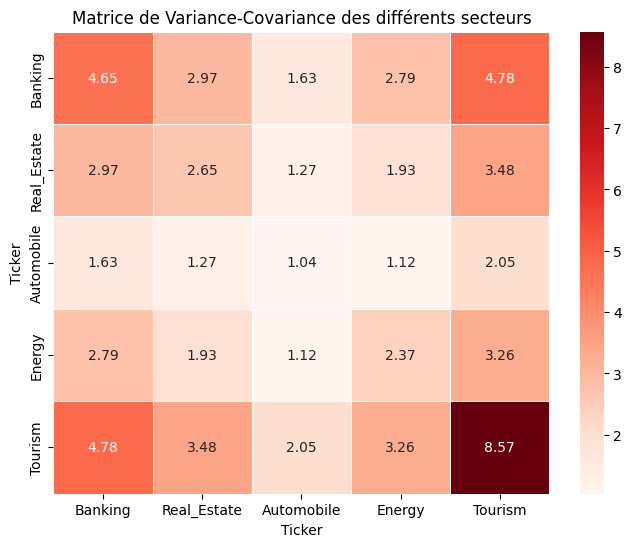

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(V, annot=True, cmap='Reds', fmt=".2f", linewidths=.5)
plt.title("Matrice de Variance-Covariance des différents secteurs")
plt.show()

## Calcul de l'allocation de Markovitz selon le calcul vu dans le cours

In [116]:
def hmarkovitz(l, lambda0):
    """
    Calcul du portefeuille de Markowitz avec contraintes de somme égale à un et rendement attendu égal à Alpha.

    Parameters:
    - l: list, [Alpha, V], où Alpha est le rendement attendu et V est la matrice de covariance des rendements.
    - lambda0: float, paramètre de contrôle du trade-off entre rendement et risque.

    Returns:
    - numpy array, le portefeuille de Markowitz calculé.
    """
    Alpha = l[0]
    V = l[1]
    nrow = V.shape[0]
    V = np.array(V)
    V_inv = np.linalg.inv(V)

    A = np.ones((1, nrow), dtype=int)

    # Calcul du premier terme du portefeuille de Markowitz
    r1 = np.concatenate(V_inv @ A.T @ (np.linalg.inv(A @ V_inv @ A.T)))

    # Calcul du deuxième terme du portefeuille de Markowitz avec la contrainte Lambda
    r2 = lambda0 * V_inv @ (Alpha - A.T @ np.linalg.inv(A @ V_inv @ A.T) @ A @ V_inv @ Alpha)

    # Retourne le portefeuille de Markowitz résultant
    return r1 + r2

Nous constatons bien une différence d'allocation selon que l'on utilise ou non le signal. Le signal induit bien une distortion de l'algorithme de Markovitz.

In [118]:
hmarkovitz(stats_dataframe(matrix_return(2015,2016), score('2015')),5)

[*********************100%***********************]  22 of 22 completed


array([ 0.04489767,  1.33842117,  0.46770069, -0.83139112, -0.01962841])

In [119]:
hmarkovitz(stats_dataframe(matrix_return(2015,2016), None),5)

[*********************100%***********************]  22 of 22 completed


array([ 0.28487882,  1.12213211,  0.11632992, -0.54917264,  0.0258318 ])

In [120]:
def calendrier(start, end):
    """
    Génère un DataFrame avec une colonne 'dates' contenant les dates mensuelles entre start et end.

    Parameters:
    - start: int, année de début.
    - end: int, année de fin.

    Returns:
    - DataFrame, contenant une colonne 'dates' avec les dates mensuelles.
    """
    # Convertit l'année de début en format de date
    start_date = pd.to_datetime(f'{start}-01-01')

    # Convertit l'année de fin en format de date et ajoute un mois pour inclure la dernière année complète
    end_date = pd.to_datetime(f'{end-1}-12-31') + pd.DateOffset(months=1)

    # Génère un DataFrame avec des dates mensuelles entre start_date et end_date
    df_dates = pd.DataFrame({
        'dates': pd.date_range(start=start_date, end=end_date, freq='MS')
    })

    return df_dates

Pour tracer le PnL, nous reprenons le code vu dans le cours et utilisons le sharpe ratio pour les 12 mois de l'année.

In [127]:
def test_year(df):
    return int(len(df) / len(df.asfreq("Y"))) == 1

def sharpe_ratio(df, num_period_per_year=12):
    num_period_per_year = 12
    if test_year(df):
        num_period_per_year = 1
    if num_period_per_year is None:
        return np.nan
    else:
        return df.mean() / df.std() * np.sqrt(num_period_per_year)
def line(
    df,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    cumsum=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    legend_sharpe_ratio=None,
    legend=True,
    yscale=None,
    start_date=None,
):
    if loc == "best":
        bbox_to_anchor = None
    if isinstance(df, dict):
        df = pd.concat(df, axis=1)
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if start_date is not None:
        df = df[start_date:]
    if cumsum & (legend_sharpe_ratio is None):
        legend_sharpe_ratio = True
    if legend_sharpe_ratio:
        df.columns = [
            f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]
    if cumsum:
        df = df.cumsum()
    if sort:
        df = df.loc[:, lambda x: x.iloc[-1].sort_values(ascending=False).index]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(df.index.values, df.values)
    if legend:
        ax.legend(df.columns, loc=loc, bbox_to_anchor=bbox_to_anchor)
    ax.set_title(title)
    if yscale == "log":
        ax.set_yscale("log")

### La fonction Backtest
Cette fonction permet le backtest de notre stratégie avec signal et sans signal (benchmark).

In [133]:
def backtest(start, end, lambda0, signal=1):
    """
    Réalise un backtest d'un portefeuille de Markowitz sur une période donnée.

    Parameters:
    - start: int, année de début.
    - end: int, année de fin.
    - lambda0: float, paramètre de contrôle du trade-off entre rendement et risque.
    - signal: Ici on choisit 1 si on inclut le signal issu du nlp et 0 sinon, cela correspond respectivement à notre stratégie ou au benchmark.

    Returns:
    - Series, le profit & loss (P&L) du portefeuille de Markowitz sur la période.
    """
    # Crée un DataFrame avec des dates mensuelles entre start+1 et end
    df = calendrier(start+1, end)

    # Initialise les colonnes du DataFrame pour chaque secteur
    df['Banking'] = 0
    df['Real_Estate'] = 0
    df['Automobile'] = 0
    df['Energy'] = 0
    df['Tourism'] = 0

    # Réalise le backtest pour chaque année de la période
    for k in range(start, end):
        # Calcule le portefeuille de Markowitz pour l'année k+1
        if signal==1:
           M = hmarkovitz( stats_dataframe(matrix_return(k, k+1), score(str(k))), lambda0 )
        if signal==0:
           M = hmarkovitz( stats_dataframe(matrix_return(k, k+1), None), lambda0 )


        # Met à jour les colonnes du DataFrame pour chaque secteur avec les poids du portefeuille M
        for date in df['dates']:
            if date.year == (k+1):
                df.loc[df['dates'] == date, ['Banking', 'Real_Estate', 'Automobile', 'Energy', 'Tourism']] = M

    # Définit les dates comme index du DataFrame
    df.set_index('dates', inplace=True)

    # Calcule le profit & loss (P&L) en multipliant les rendements par les poids du portefeuille pour chaque date
    pnl = df.mul(matrix_price_pnl(start+1, end)).sum(axis=1)

    # Affiche la courbe du P&L cumulatif du portefeuille de Markowitz
    if signal==0:
       line(pnl.rename('Portofolio de Markovitz'), cumsum=True)
    if signal==1:
       line(pnl.rename('Portofolio de Markovitz et signal'), cumsum=True)

    return pnl

## Présentation des résultats
Pour les différents coefficients lambda que nous avons pu observer (3ème paramètre de la fonction backtest), notre stratégie par rapport au benchmark présente un avantage de l'ordre de 10% du sharpe ratio sur 8 ans. Ici, nous présentons les deux graphiques pour un coefficient d'aversion au risque de 1.

[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed


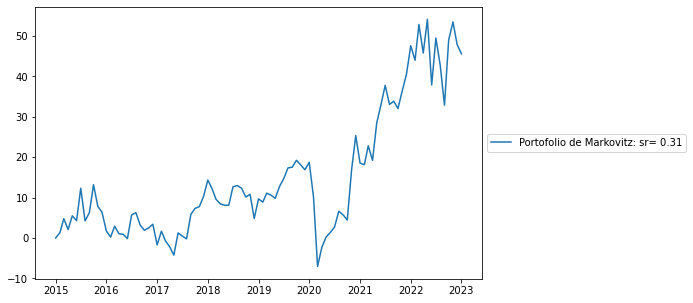

In [129]:
holds=backtest(2014,2023,5,0)

[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  22 of 22 completed


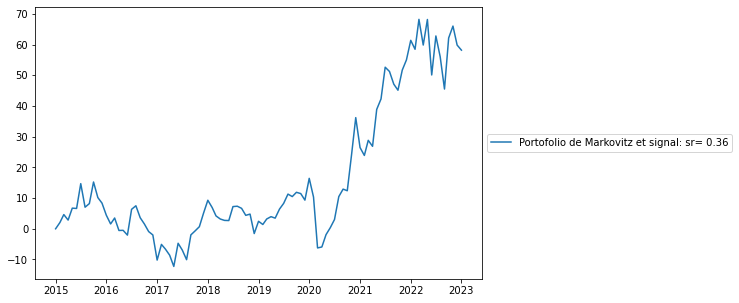

In [134]:
holds=backtest(2014,2023,5,1)